In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit import (
    QuantumCircuit, 
    Aer, 
    IBMQ, 
    assemble, 
    transpile,
    execute,
)
import openfermion as of
from openfermion import (
    linalg as of_lg
)
from qiskit.test.mock import FakeAthens
import scipy
import math
IBMQ.save_account("5743a5c607636e43b7431c0370ec874af29cbf102ad69bcfc87a0fbbd1cf560fd841e69aef0e96eb0e1b6e3a59c5c3d72d89623b46f0964099e0195708aa9c05")

configrc.store_credentials:WARNING:2022-03-18 07:51:08,045: Credentials already present. Set overwrite=True to overwrite.


In [2]:
def getInvDiag(in_matrix):
	a = np.matmul(in_matrix, np.transpose(in_matrix.conjugate()))
	a = scipy.linalg.fractional_matrix_power(a, 0.5)

	return np.linalg.inv(a)

def GivensRotations():
	nsites = 2
	#* Parameters for setting up the Gaussian potential.
	l_up = 1
	m_up = 1.5
	sigma_up = 1
	#* For spin-dependent potentials

	site_index = np.arange(1, nsites + 1)
	spin_up_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)
	spin_up_ham += np.diag(-l_up * np.exp(-0.5 * ((site_index - m_up)**2) / (sigma_up**2)))
	spin_up_ham_u = np.matmul(getInvDiag(spin_up_ham), spin_up_ham)

	spin_down_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)
	spin_down_ham_u = np.matmul(getInvDiag(spin_down_ham), spin_down_ham)

	up_decomp, up_diag = of_lg.givens_decomposition_square(spin_up_ham_u)
	down_decomp, down_diag = of_lg.givens_decomposition_square(spin_down_ham_u)

	# print(up_decomp)
	# print(down_decomp)
	# for t in up_decomp:
	# 	print("set = {}".format(t))

	return (up_decomp[0][0][2], down_decomp[0][0][2])

In [3]:
def getRootiSwapHC(qc=QuantumCircuit(2)):
    qc.rxx(math.pi / 4, 0, 1)
    qc.ryy(math.pi / 4, 0, 1)
    return qc.to_instruction(label="√iSWAP†")
    
def getRootiSwap(qc=QuantumCircuit(2)):
    qc.z(0)
    qc.append(getRootiSwapHC(), [0, 1])
    qc.z(0)
    return qc.to_instruction(label="√iSWAP")

def getGGate(a:float, gate_label:str, qc=QuantumCircuit(2)):
    qc.append(getRootiSwap(), [0, 1])
    qc.rz(-a, 0)
    qc.rz(a, 1)
    qc.append(getRootiSwapHC(), [0, 1])
    return qc.to_instruction(label=gate_label)
    
    
def getKGate(a:float, qc=QuantumCircuit(2), label:str="θ"):
    qc.rz(-(math.pi / 4), 0)
    qc.rz((math.pi / 4), 1)
    qc.append(getRootiSwap(), [0, 1])
    qc.rz(a, 0)
    qc.rz(-a, 1)
    qc.append(getRootiSwapHC(), [0, 1])
    qc.rz((math.pi / 4), 0)
    qc.rz(-(math.pi / 4), 1)
    return qc.to_instruction(label="K(" + label + ")")

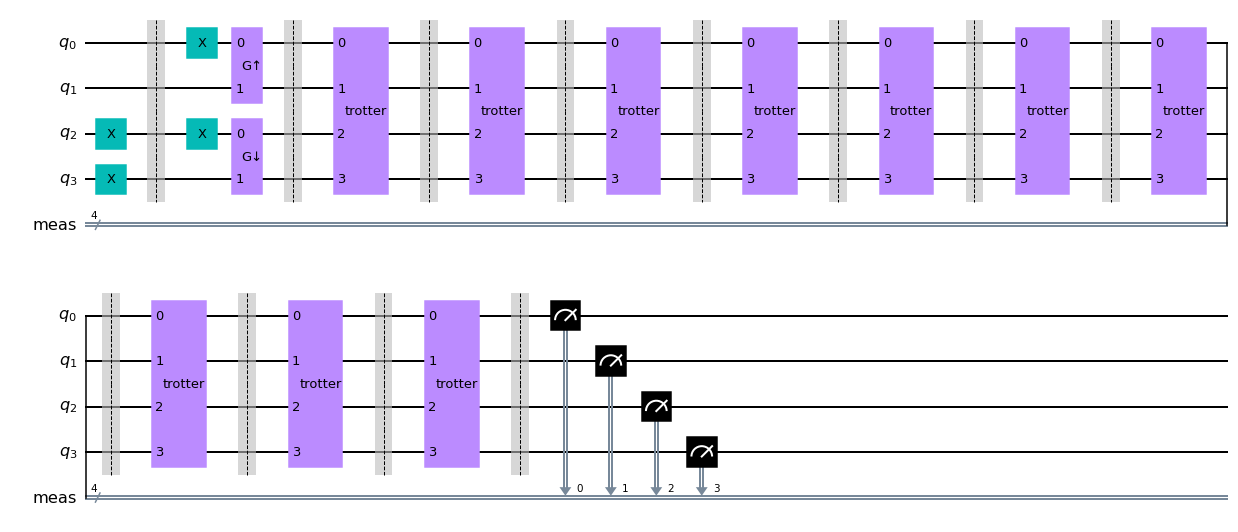

In [4]:
def PreInitPrep(qc:QuantumCircuit):
    for i in range(2, 4):
        qc.x(i)

def ApplyInitialPreparation(m:QuantumCircuit):
    m.x(0)
    m.x(2)

    up_G, down_G = GivensRotations()
    
    m.append(getGGate(up_G, gate_label="G↑"), [0, 1])
    m.append(getGGate(down_G, gate_label="G↓"), [2, 3])

def ApplyTrotter(m=QuantumCircuit(4)):
    m.append(getKGate(-0.3), [0, 1])
    m.append(getKGate(-0.3), [2, 3])
    m.cp(0.9, control_qubit=0, target_qubit=2)
    m.iswap(0, 1)
    m.iswap(2, 3)
    m.cp(0.9, control_qubit=0, target_qubit=2)
    m.append(getKGate(-0.3 + math.pi/2, qc=QuantumCircuit(2), label="θ + π/2"), [0, 1])
    m.append(getKGate(-0.3 + math.pi/2, qc=QuantumCircuit(2), label="θ + π/2"), [2, 3])

    return m.to_instruction(label="trotter")

circuit = QuantumCircuit(4)
PreInitPrep(circuit)
circuit.barrier()
ApplyInitialPreparation(circuit)
for i in range(0, 10):
    circuit.barrier()
    circuit.append(ApplyTrotter(), list(range(0, 4)))

circuit.measure_all()
circuit.draw(output="mpl")

In [5]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend("ibmq_santiago")

counts = execute(circuit, device, shots=4000).result().get_counts()
plot_histogram(counts)

IBMQBackendApiError: "Error submitting job: '403 Client Error: Forbidden for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/623443c6885fa2091216e113/jobDataUploaded. Your job is too long., Error code: 3248.'"

In [ ]:
device = provider.get_backend("ibmq_quito")

counts = execute(circuit, device, shots=4000).result().get_counts()
plot_histogram(counts)

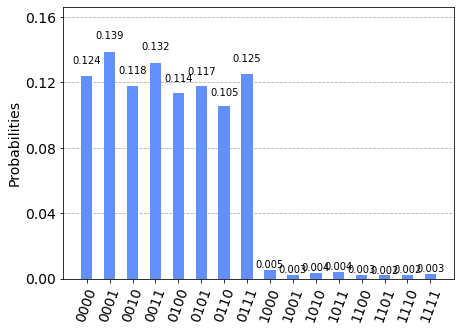

In [7]:
device = provider.get_backend("ibmq_lima")

counts = execute(circuit, device, shots=4000).result().get_counts()
plot_histogram(counts)